In [1]:
import copy
import random
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.imagenet_utk import ImagenetUtk

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s for training/validating the model" % device)
torch.manual_seed(0)


# TODO: Fix
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Using cuda:0 for training/validating the model


## Data Preprocessing

In [2]:
# Parameter settings for batching
batch_size = 64
shuffle = True

# Load data for UTK
image_datasets = {'train': ImagenetUtk(base_dir="./datasets", image_size=64),
                  'val': ImagenetUtk(base_dir="./datasets", image_size=64, validation=True)}
dataloaders = {'train': DataLoader(dataset=image_datasets['train'], batch_size=batch_size,
                                   shuffle=shuffle, num_workers=0, worker_init_fn=seed_worker),
               'val': DataLoader(dataset=image_datasets['val'], batch_size=batch_size,
                                 shuffle=shuffle, num_workers=0, worker_init_fn=seed_worker)}

# this classes list will contain class names of items[0] to [9] in string
class_names = image_datasets['train'].get_class_names()

Images to get per class: 63
Current gender: male	Current race: white Current class size:5477
Current gender: male	Current race: black Current class size:2318
Current gender: male	Current race: asian Current class size:2261
Current gender: male	Current race: indian Current class size:760
Current gender: female	Current race: white Current class size:4601
Current gender: female	Current race: black Current class size:2208
Current gender: female	Current race: asian Current class size:1714
Current gender: female	Current race: indian Current class size:932
Total length of training dataset: 504
Total length of validation dataset: 56

Resized training images. Saved at ./datasets/modified_datasets/utk/train
Resized validation images. Saved at ./datasets/modified_datasets/utk/val

Training list saved as: ./datasets/modified_datasets/utk/train.json
Validation list saved as: ./datasets/modified_datasets/utk/validation.json

UTKFace training list loaded from: ./datasets/modified_datasets/utk/train.j

In [ ]:
def info_data() -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    print('number of classes:', len(class_names))
    print('class names:', class_names)
    print('length of training dataset:', len(image_datasets['train']))
    print('length of validation dataset:', len(image_datasets['val']))
    print('batch size:', batch_size)
    print('number of batches in the training dataloader:', len(dataloaders['train']))
    print('number of batches in the training dataloader:', len(dataloaders['val']))
    print('device:', device)


info_data()

## Dataset preview

530


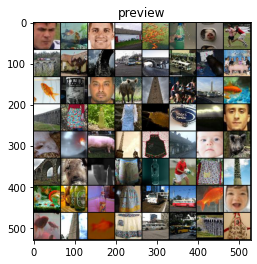

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(len(inp))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(60)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
imshow(out, title="preview")

## Model Training

In [4]:
# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1

model_ft = models.resnet50()

num_ftrs = model_ft.fc.in_features

# TODO: Here the size of each output sample is set to 2 it is the number of classes.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY, momentum=SGD_MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
# TODO: Perhaps we can consider ReduceLROnPlateau instead
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)


def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for imgs, labels in dataloaders[phase]:
                # print('Iterating ', labels, '...')
                torch.cuda.empty_cache()  # clean up cache
                #print(torch.cuda.memory_summary(device=device, abbreviated=False))
                imgs = imgs.float().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.eq(preds, labels.data).sum()
            if phase == 'train':
                scheduler.step()
            dataset_size = len(image_datasets[phase])
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler, EPOCH)

Epoch 0/24
----------
train Loss: 2.2872 Acc: 0.1515
val Loss: 2.3467 Acc: 0.2252

Epoch 1/24
----------
train Loss: 2.0392 Acc: 0.2762
val Loss: 1.9027 Acc: 0.3071

Epoch 2/24
----------
train Loss: 1.8823 Acc: 0.3445
val Loss: 1.7913 Acc: 0.3771

Epoch 3/24
----------
train Loss: 1.6904 Acc: 0.4145
val Loss: 1.6702 Acc: 0.3960

Epoch 4/24
----------
train Loss: 1.5883 Acc: 0.4357
val Loss: 1.4580 Acc: 0.4906

Epoch 5/24
----------
train Loss: 1.4667 Acc: 0.4890
val Loss: 1.4532 Acc: 0.4794

Epoch 6/24
----------
train Loss: 1.3586 Acc: 0.5200
val Loss: 1.2319 Acc: 0.5748

Epoch 7/24
----------
train Loss: 1.1864 Acc: 0.5895
val Loss: 1.1411 Acc: 0.6141

Epoch 8/24
----------
train Loss: 1.1217 Acc: 0.6159
val Loss: 1.0892 Acc: 0.6409

Epoch 9/24
----------
train Loss: 1.0750 Acc: 0.6365
val Loss: 1.0255 Acc: 0.6642

Epoch 10/24
----------
train Loss: 1.0469 Acc: 0.6483
val Loss: 0.9836 Acc: 0.6859

Epoch 11/24
----------
train Loss: 1.0179 Acc: 0.6593
val Loss: 0.9413 Acc: 0.7068

Ep

## Model Visualization

In [34]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(('predicted:' + class_names[preds[j]] +
                              '\n answer:' + class_names[labels.cpu().numpy()[images_so_far - 1]]))
                imshow(inputs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

64
64
64
64
64
64
64
64
64
64


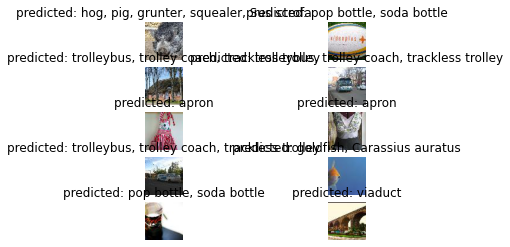

In [35]:
visualize_model(model_ft)